# Import all the required modules


In [ ]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
#bikes = pd.read_csv("/content/drive/MyDrive/BikeSharingAssignment/day.csv")
bikes = pd.read_csv("day.csv")
bikes.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


#Common Utility Methods

In [ ]:
def analyze_column_against_count(df, column_name):
  """
    The below function performs univariate analysis on a column in a DataFrame
    by first checking for data type of whether its numerical type or categorical type
    abd create plots

    For the numerical data, it plots the distribution with KDE curve, histogram,
    boxplot and also indicates the mean

    For the categorical variable, it plots the box and bar plot against the rental
    count. In the case of bar plot, it also plots based on count for different years

    Args:
        df (pandas.DataFrame): The DataFrame containing the data.
        column (str): The name of the column to analyze.

    Returns:
        None
  """
  fig, axes = plt.subplots(1, 2, figsize=(16, 4), dpi=100)
  # Check data type
  if pd.api.types.is_numeric_dtype(df[column_name]):
    # Numerical data - Create box plot
    median = df[column_name].median()
    plt.xlabel(column_name)
    axes[0].axvline(median, color="green", linestyle="--", label=f"Median: {median:.2f}")
    axes[0].legend()
    sns.distplot(df[column_name], kde=True, hist=True, ax=axes[0], label=True)
    axes[0].set_title(f"Distribution with KDE and Histogram for {column_name}")
    sns.boxplot(x = column_name, showmeans=True, data=df, ax=axes[1])
    plt.title("Box Plot of " + column_name)
  else:
    # Categorical data - Create box plot
    axes[0].set_title("Box Plot of Count by" + column_name)
    sns.boxplot(x = column_name, y='cnt', showmeans=True, data=df, ax=axes[0])

    # Bar plot with legend based on hue
    sns.barplot(x = column_name, y='cnt', hue='year', data=df, ax=axes[1])
    handles, labels = axes[1].get_legend_handles_labels()  # Get legend elements

    # Create custom legend with colors corresponding to years
    by_label = dict(zip(['2018', '2019'], handles))
    axes[1].legend(by_label.values(), by_label.keys(), title="Year")  # Set legend with colors and labels
    axes[1].set_title("Bar chart of rentals count by " + column_name + " for different years")

  plt.show()

In [ ]:
def draw_scatter_plot_with_correlation_line(df, x_column_name, y_column_name):
  """
    The below function draws the scatter plot btween values of x and y columns
    and also computes slope and intercept and draws a linear relationship line

    Args:
        df (pandas.DataFrame): The DataFrame containing the data.
        column (str): The x-axis name of the column to plot.
        column (str): The y-axis name of the column to plot

    Returns:
        None
  """
  x = np.array(df[x_column_name])
  y = np.array(df[y_column_name])

  # Create scatter plot
  plt.scatter(x, y)

  # Calculate correlation coefficient
  correlation = np.corrcoef(x, y)[0, 1]  # Get correlation coefficient from covariance matrix

  # Fit a linear regression line
  m, b = np.polyfit(x, y, 1)  # Get slope (m) and intercept (b)
  plt.plot(x, m*x + b, color='red')  # Plot the regression line

  # Add labels and title
  plt.xlabel("temperature")
  plt.ylabel("cnt")
  plt.title("Scatter Plot with Correlation Line")

  # Add correlation coefficient to plot
  plt.text(0.7, 0.8, f"Correlation: {correlation:.3f}", ha='center', va='center', fontsize=10, bbox=dict(boxstyle="round", facecolor='white', alpha=0.7))

  plt.show()

In [ ]:
def build_statsmodel_ols(X_train, y_train):
  """
  Builds a linear regression model using statsmodels with a constant term.
  Prints the computed pattern params to view the const intercepts and feature
  coefficients

  Args:
      X_train (pd.DataFrame): The training features.
      y_train (pd.Series): The training target variable.

  Returns:
      statsmodels.OLS: The fitted OLS model object.
  """

  # Add a constant term for intercept
  X_train_sm = sm.add_constant(X_train)

  # Build the OLS model
  model = sm.OLS(y_train, X_train_sm)

  # Fit the model
  model_fit = model.fit()

  #lets print the params
  print(model_fit.params)

  # Return the fitted model
  return model_fit

In [ ]:
def compute_and_return_rfe(X_train, y_train, n_features_to_select=15):
  """
  computes Recursive Feature Elimination (RFE) and returns the RFE object.

  Args:
      X_train (pd.DataFrame): The training features.
      y_train (pd.Series): The training target variable.
      n_features_to_select (int, optional): The number of features to
                                             select using RFE.
                                             Defaults to 15.

  Returns:
      sklearn.feature_selection.rfe.RFE: The RFE object containing
                                         the selected features.
  """

  # Create a Linear Regression estimator
  lr = LinearRegression()

  # Create RFE object
  rfe = RFE(estimator=lr, n_features_to_select=n_features_to_select)

  # Fit RFE on training data
  rfe = rfe.fit(X_train, y_train)

  # Return the RFE object
  return rfe

In [ ]:
def get_stats_summary(X_train_dataset, rfe_support):
    """
    This function retrieves and printes the summary of the statistical properties
    of the model using smstat and returns the computed rfe object of X_train

    Args:
        X_train_dataset (pandas.DataFrame): The training dataset.
        rfe_support (np.ndarray): The list of features selected by RFE.

    Returns:
        selected features (X_train_rfe)
        and (prints the summary to the console)
    """

    # Select features based on RFE support
    X_train_rfe = X_train_dataset.iloc[:, rfe_support]

    # Add constant term for intercept
    X_train_rfe = sm.add_constant(X_train_rfe)

    # Fit the OLS model and print the summary
    model = sm.OLS(y_train, X_train_rfe).fit()
    print(model.summary())
    return X_train_rfe

In [ ]:
def print_vif_data(dataset: pd.DataFrame) -> None:
    """
    Prints a DataFrame containing feature names and their respective VIFs, sorted in descending VIF order.

    Args:
        dataset (pd.DataFrame): The dataset containing the features.

    Returns:
        None (prints the DataFrame to the console)
    """

    # Create a DataFrame to store VIF values
    vif_df = pd.DataFrame({'Features': dataset.columns})

    # Calculate VIF for each feture
    vif_df['VIF'] = [variance_inflation_factor(dataset.values, i) for i in range(dataset.shape[1])]
    vif_df['VIF'] = vif_df['VIF'].round(2)
    #print sorted result
    print(vif_df.sort_values(by='VIF', ascending=False))

#Data understanding, preparation and EDA

In [ ]:
bikes.shape

(730, 16)

The bikes dataframe shows there are 730 rows and 16 variables (columns)

In [ ]:
#check for any null rows and datatypes
bikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [ ]:
bikes.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


##Cleaning Data

Some of the columns that are not wanted could be removed from analysis
1. **"instant"** column is just a record identifier and not any use for data analysis
2. **"dteday"** is already available in more detailed form as yr, month and so on, so could be dropped as well
3. The 2 fields **'casual'** and **'registered'**, the sum of which is the target variable cnt, so could be dropped as well straight away.


In [ ]:
bikes.drop(['instant', 'dteday', 'casual', 'registered'], axis=1, inplace=True)

From the data dictionary, the other columns 'temp' and 'atemp' has following definitions:
- temp : temperature in Celsius
- atemp: feeling temperature in Celsius

The feeling temperature is actually a calculated value derived from the actual measured air temperature, humidity and windspeed and more., so lets ascertain if the temperature (temp) and feels like temperature (atemp) are correlated and drop one of them.

correlation between temp and atemp columns is 0.991696178690565


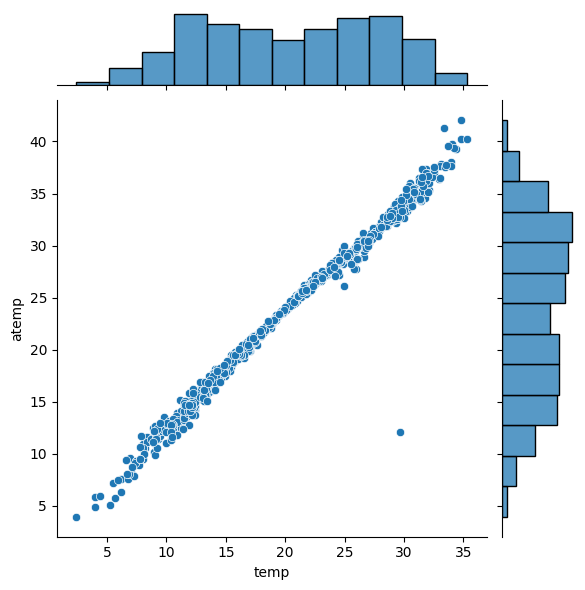

In [ ]:
sns.jointplot(x=bikes['temp'], y=bikes['atemp'])
print(f"correlation between temp and atemp columns is {bikes['temp'].corr(bikes['atemp'])}")

From the above scatter and histogram plots, it is very clear that temp and atemp are linearly correlated and having a correlation index of approximately 1, therefore hey are effectively the same, so 'atemp' column could be dropped against the measured temperature

In [ ]:
bikes.drop('atemp', axis=1, inplace=True)

In [ ]:
bikes.describe()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,62.765175,12.763620,4508.006849
std,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,14.237589,5.195841,1936.011647
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,0.000000,1.500244,22.000000
25%,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,52.000000,9.041650,3169.750000
50%,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,62.625000,12.125325,4548.500000
75%,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,72.989575,15.625589,5966.000000
max,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,97.250000,34.000021,8714.000000


In [ ]:
bikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    int64  
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    int64  
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    int64  
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    int64  
 7   temp        730 non-null    float64
 8   hum         730 non-null    float64
 9   windspeed   730 non-null    float64
 10  cnt         730 non-null    int64  
dtypes: float64(3), int64(8)
memory usage: 62.9 KB


## Cleanup and Analyse Numeric Variables

Lets skip the categorical variables for now to identify any multicollinearity wtih numerical variables.

                 cnt      temp   holiday  workingday       hum  windspeed
cnt         1.000000  0.627044 -0.068764    0.062542 -0.098543  -0.235132
temp        0.627044  1.000000 -0.028764    0.053470  0.128565  -0.158186
holiday    -0.068764 -0.028764  1.000000   -0.252948 -0.015662   0.006257
workingday  0.062542  0.053470 -0.252948    1.000000  0.023202  -0.018666
hum        -0.098543  0.128565 -0.015662    0.023202  1.000000  -0.248506
windspeed  -0.235132 -0.158186  0.006257   -0.018666 -0.248506   1.000000


<Axes: >

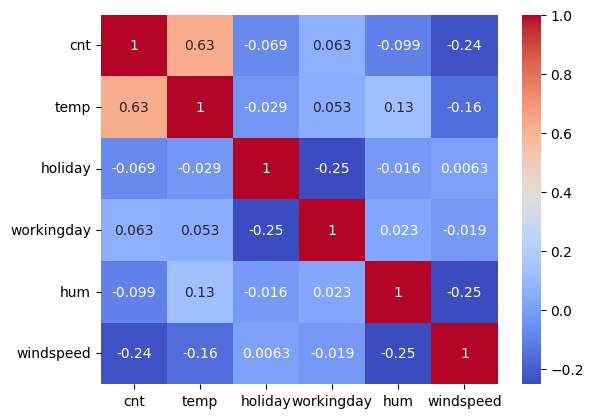

In [ ]:
correlationMatrix = bikes[['cnt','temp', 'holiday', 'workingday', 'hum', 'windspeed']].corr()
print(correlationMatrix)
sns.heatmap(correlationMatrix, annot=True, cmap='coolwarm')

So, from above heatmap, we cannot find any multicollinearity (generally accepted rule of greater than 0.7 or 0.8) between independent variables. Lets again verify and confirm by using a scatter plot.

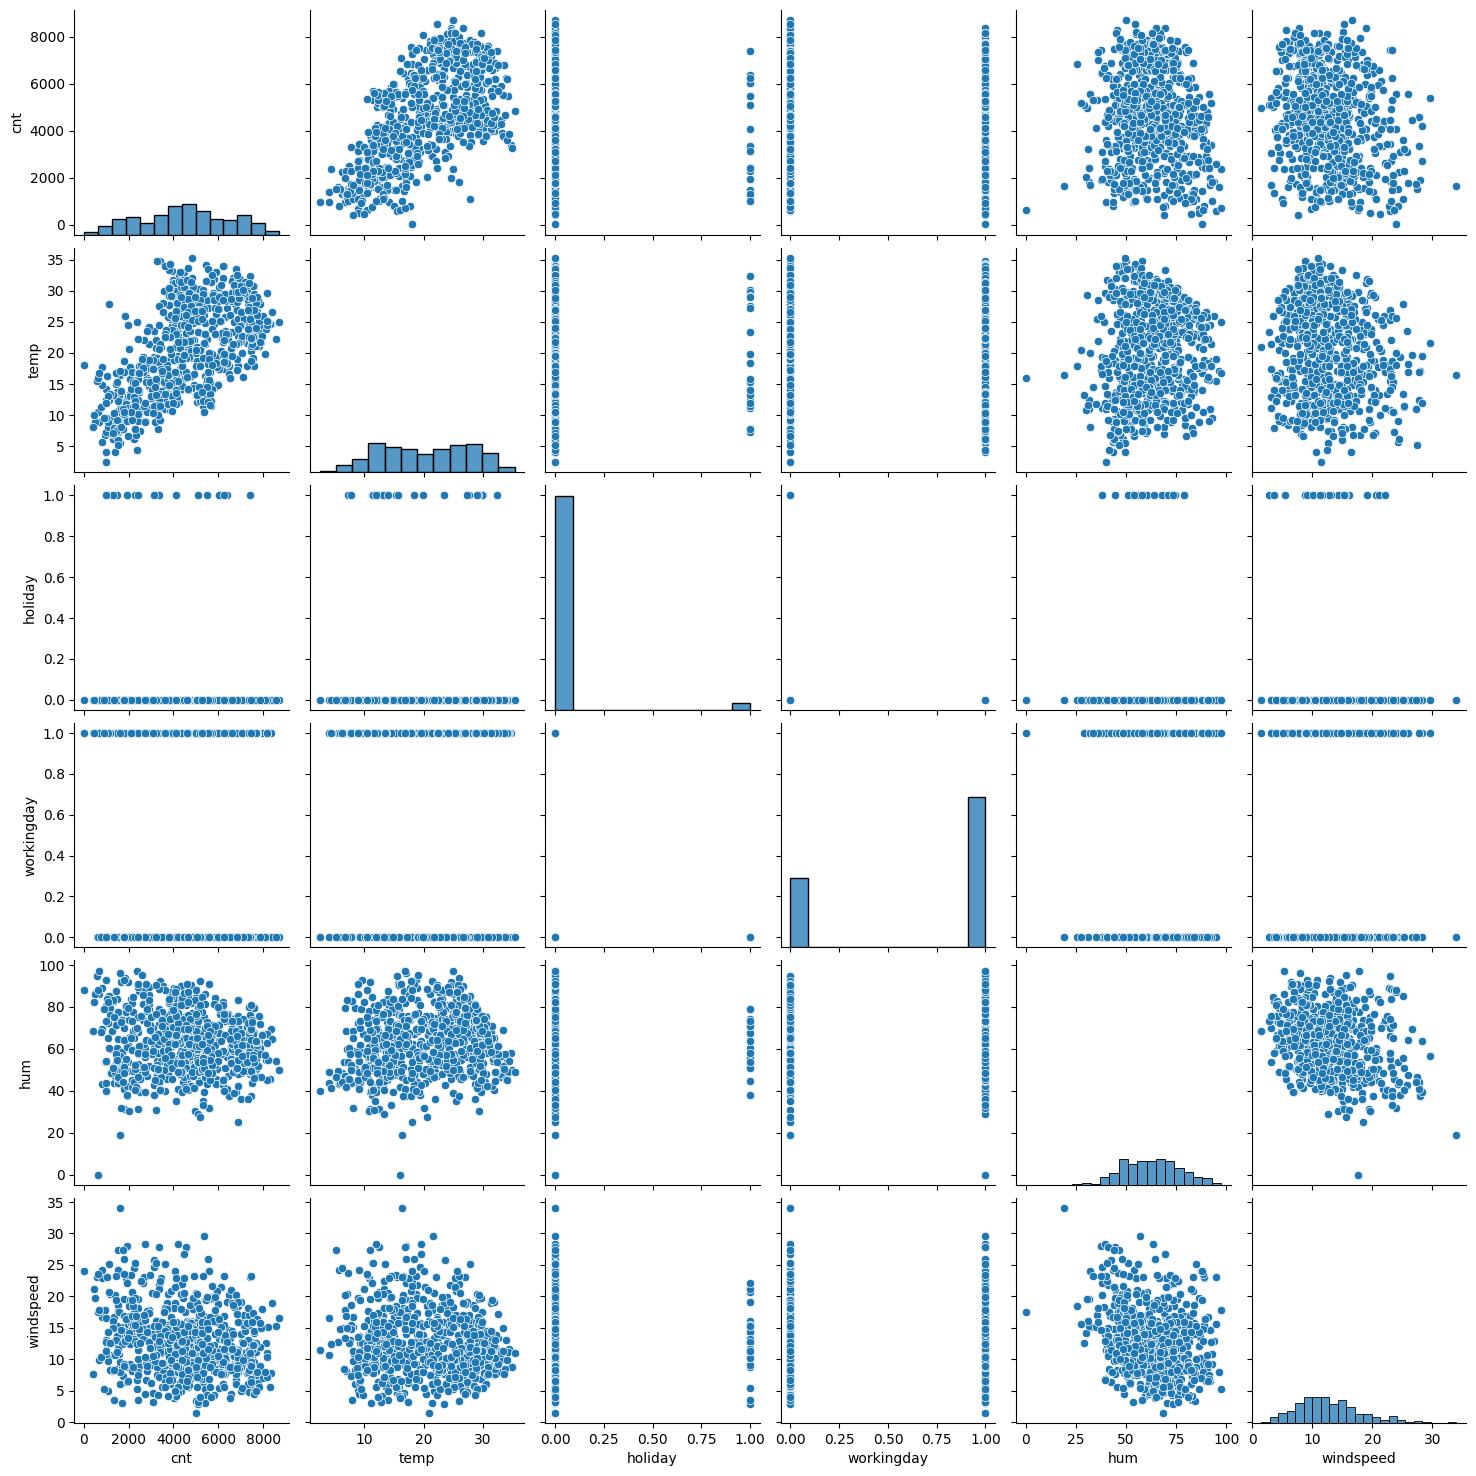

In [ ]:
sns.pairplot(bikes[['cnt','temp', 'holiday', 'workingday', 'hum', 'windspeed']])

From the above plots we cannot find any linear or curvilinear relationship between feature variables. We will further analyse later sections using VIF (Variance Inflation Factor) score's. Let's now process the categorical variables.

## Process and Analyse Categorical Variables

In [ ]:
bikes.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,14.110847,80.5833,10.749882,985
1,1,0,1,0,0,0,2,14.902598,69.6087,16.652113,801
2,1,0,1,0,1,1,1,8.050924,43.7273,16.636703,1349
3,1,0,1,0,2,1,1,8.200000,59.0435,10.739832,1562
4,1,0,1,0,3,1,1,9.305237,43.6957,12.522300,1600


We look at the data dictionary and encode the classifier's to later create dummy variables

In [ ]:
#encoding season : season (1:spring, 2:summer, 3:fall, 4:winter)
bikes.season = bikes.season.map({1:'Spring', 2:'Summer', 3:'Fall', 4:'Winter'})
bikes['season'].value_counts()
bikes.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,Spring,0,1,0,6,0,2,14.110847,80.5833,10.749882,985
1,Spring,0,1,0,0,0,2,14.902598,69.6087,16.652113,801
2,Spring,0,1,0,1,1,1,8.050924,43.7273,16.636703,1349
3,Spring,0,1,0,2,1,1,8.200000,59.0435,10.739832,1562
4,Spring,0,1,0,3,1,1,9.305237,43.6957,12.522300,1600


In [ ]:
# encoding months : month ( 1 to 12)
bikes.mnth = bikes.mnth.map({1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul',8: 'Aug',9: 'Sep',10: 'Oct',11: 'Nov',12: 'Dec'})
bikes.mnth.value_counts()


Jan    62
Mar    62
May    62
Jul    62
Aug    62
Oct    62
Dec    62
Apr    60
Jun    60
Sep    60
Nov    60
Feb    56
Name: mnth, dtype: int64

In [ ]:
bikes.holiday.value_counts()

0    709
1     21
Name: holiday, dtype: int64

In [ ]:
bikes.weekday.value_counts()

6    105
0    105
1    105
2    104
4    104
5    104
3    103
Name: weekday, dtype: int64

In [ ]:
bikes[bikes.holiday == 1].head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
16,Spring,0,Jan,1,1,0,2,7.209153,53.7500,12.999139,1000
51,Spring,0,Feb,1,1,0,2,12.436653,60.5000,20.625682,1107
104,Summer,0,Apr,1,5,0,1,18.313347,67.1250,15.167125,3126
149,Summer,0,May,1,1,0,1,30.066653,68.5000,8.792075,4098
184,Fall,0,Jul,1,1,0,2,29.793347,63.7917,5.459106,6043


In [ ]:
#encodig weekday : day of the week based on 01-01-2018 being Monday
bikes.weekday = bikes.weekday.map({0:'Tue',1:'Wed',2:'Thu',3:'Fri',4:'Sat',5:'Sun',6:'Mon',})
bikes.weekday.value_counts()

Mon    105
Tue    105
Wed    105
Thu    104
Sat    104
Sun    104
Fri    103
Name: weekday, dtype: int64

Encoding the classifier Weathersit based on following info from data dictionary
weathersit :

		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

In [ ]:
# encoding weathersit classifier
bikes.weathersit = bikes.weathersit.map({1:'Clear',2:'Mist',3:'LightSnow',4:'HeavySnow'})
bikes.weathersit.value_counts()

Clear        463
Mist         246
LightSnow     21
Name: weathersit, dtype: int64

In [ ]:
# for better readability, let us rename few columns
bikes.rename(columns={'yr':'year', 'mnth':'month', 'hum':'humidity', 'weathersit':'weather'}, inplace=True)

In [ ]:
bikes.head()

,season,year,month,holiday,weekday,workingday,weather,temp,humidity,windspeed,cnt
0,Spring,0,Jan,0,Mon,0,Mist,14.110847,80.5833,10.749882,985
1,Spring,0,Jan,0,Tue,0,Mist,14.902598,69.6087,16.652113,801
2,Spring,0,Jan,0,Wed,1,Clear,8.050924,43.7273,16.636703,1349
3,Spring,0,Jan,0,Thu,1,Clear,8.200000,59.0435,10.739832,1562
4,Spring,0,Jan,0,Fri,1,Clear,9.305237,43.6957,12.522300,1600


In [ ]:
bikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    object 
 1   year        730 non-null    int64  
 2   month       730 non-null    object 
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    object 
 5   workingday  730 non-null    int64  
 6   weather     730 non-null    object 
 7   temp        730 non-null    float64
 8   humidity    730 non-null    float64
 9   windspeed   730 non-null    float64
 10  cnt         730 non-null    int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 62.9+ KB


## Univariate and Bivariate Analysis

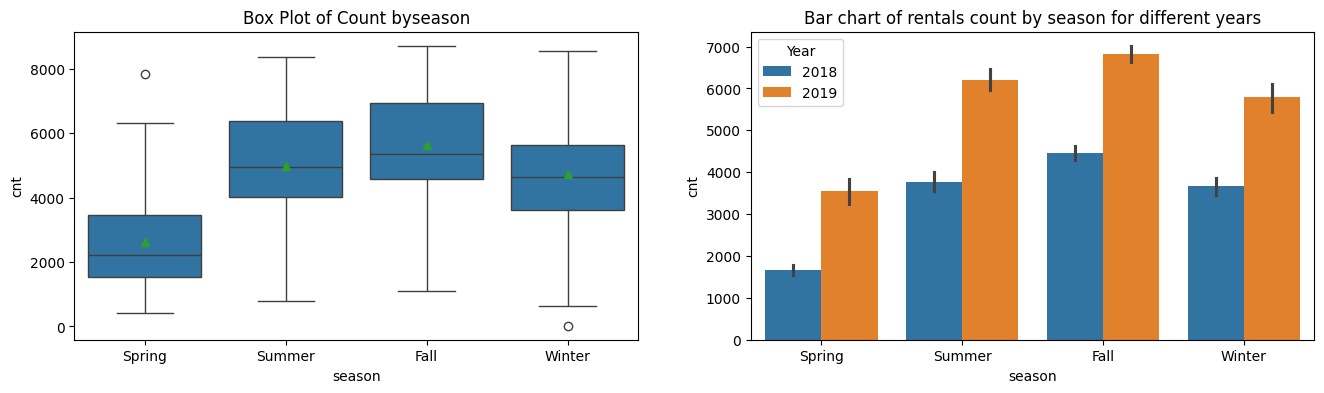

In [ ]:
analyze_column_against_count(bikes, 'season')

The Average bike rental is higher in Fall and Summer. Also, 2019 seems to have higher business in all quarters

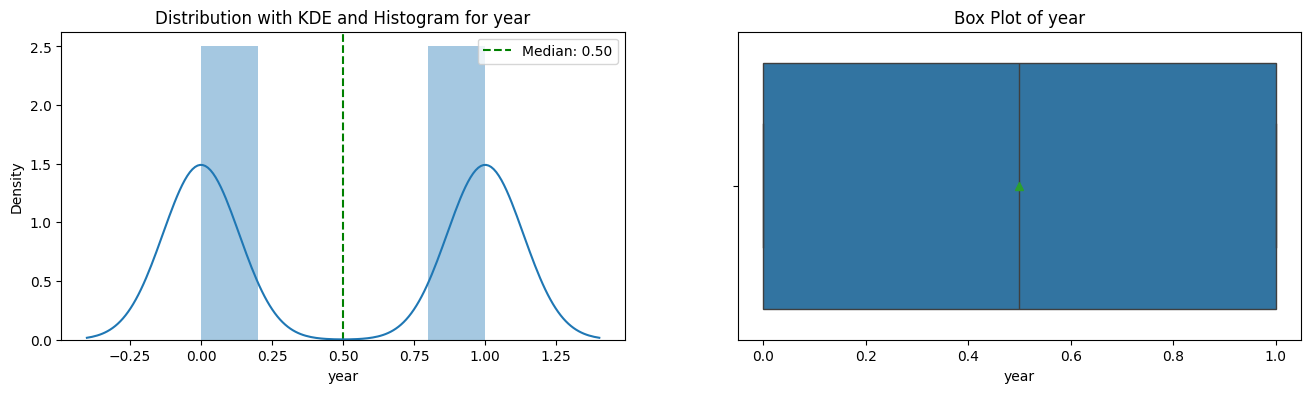

In [ ]:
analyze_column_against_count(bikes, 'year')

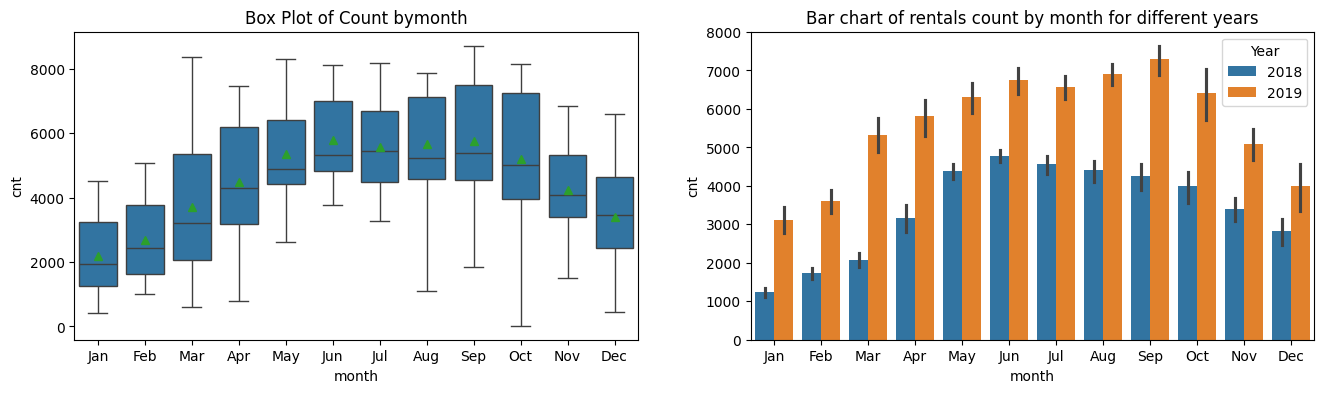

In [ ]:
analyze_column_against_count(bikes, 'month')


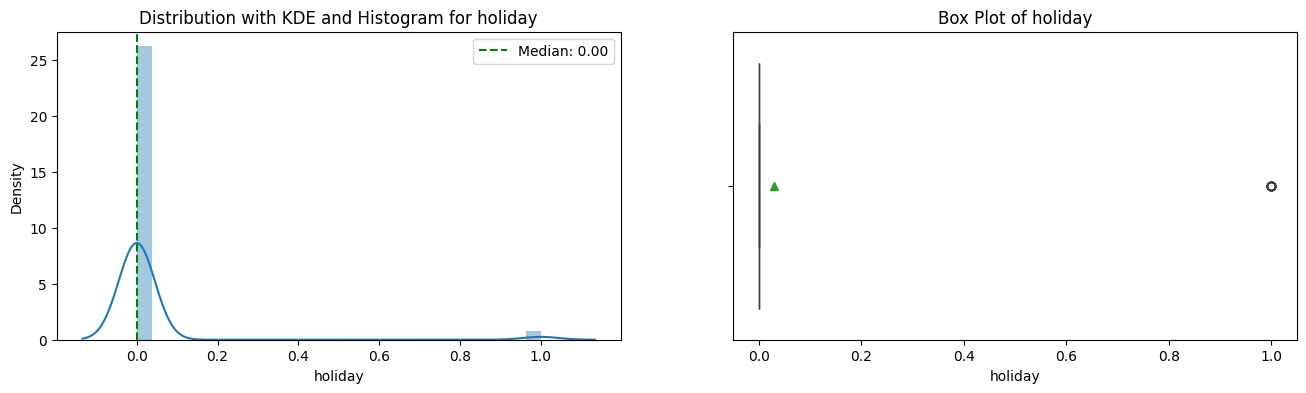

In [ ]:
analyze_column_against_count(bikes, 'holiday')


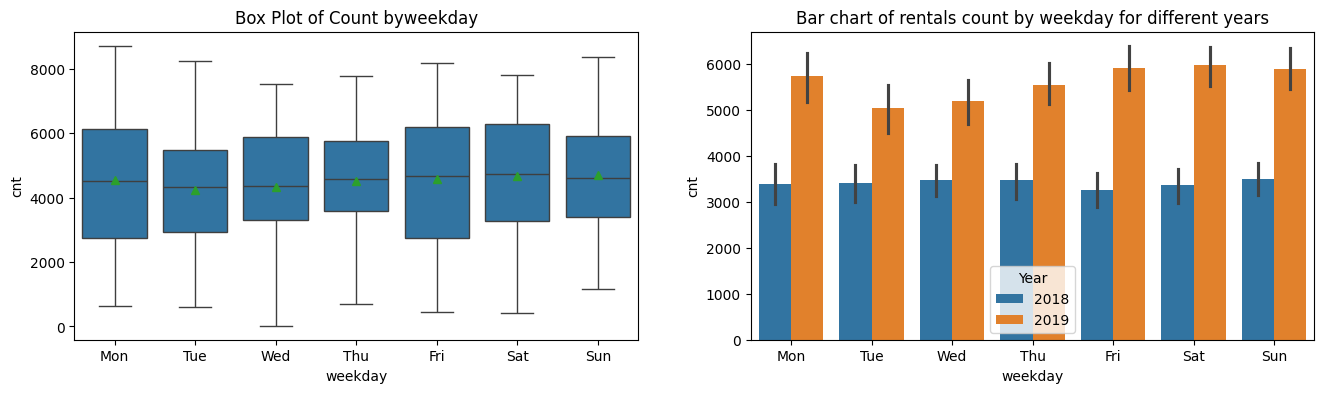

In [ ]:
analyze_column_against_count(bikes, 'weekday')


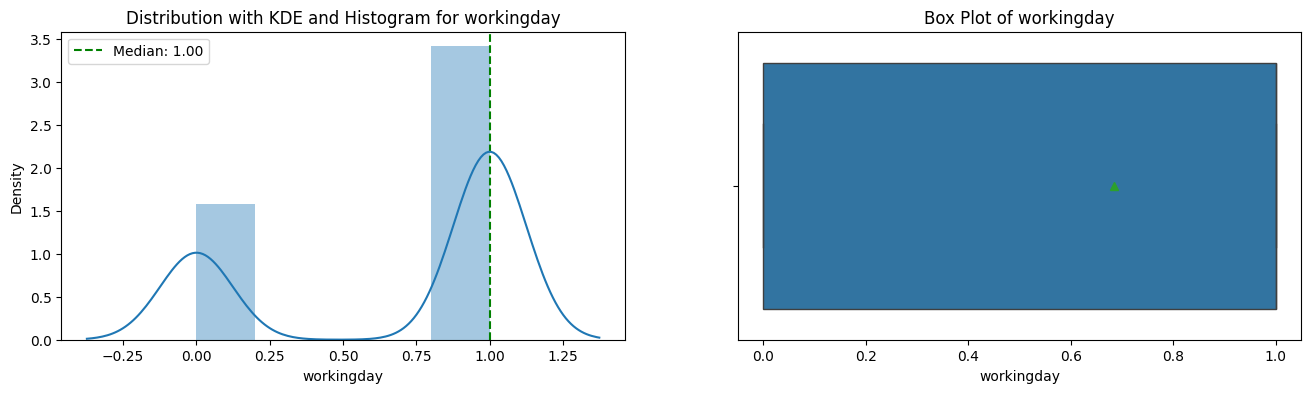

In [ ]:
analyze_column_against_count(bikes, 'workingday')


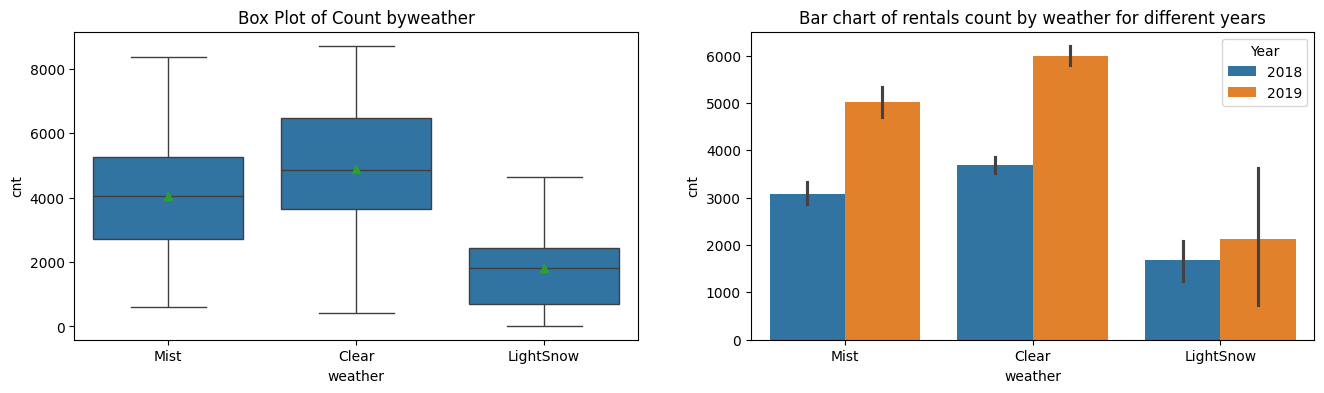

In [ ]:
analyze_column_against_count(bikes, 'weather')

Inference: More Rental count achieved when there is Clear weather when comparing to previous year, i.e 2018, there is increase for every weather condition in 2019.

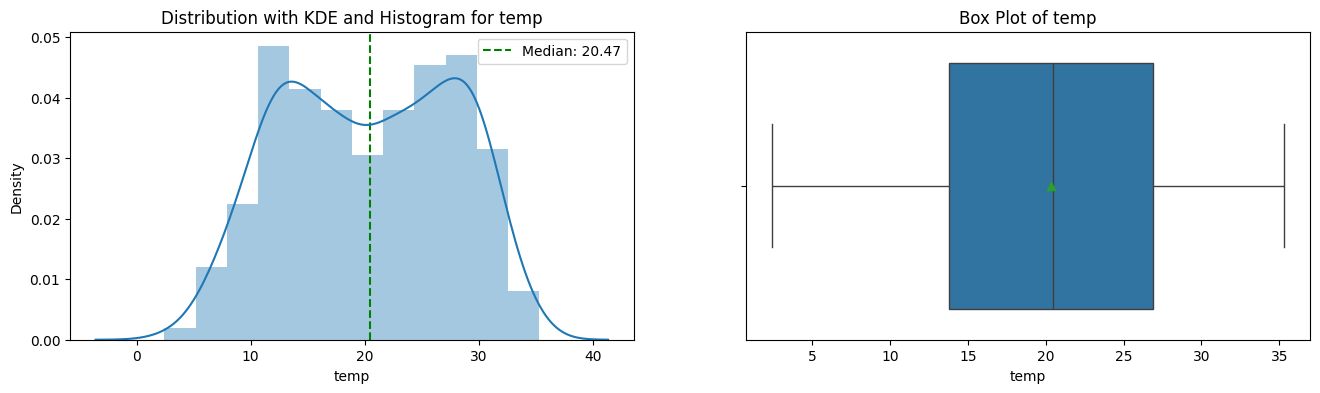

In [ ]:
analyze_column_against_count(bikes, 'temp')

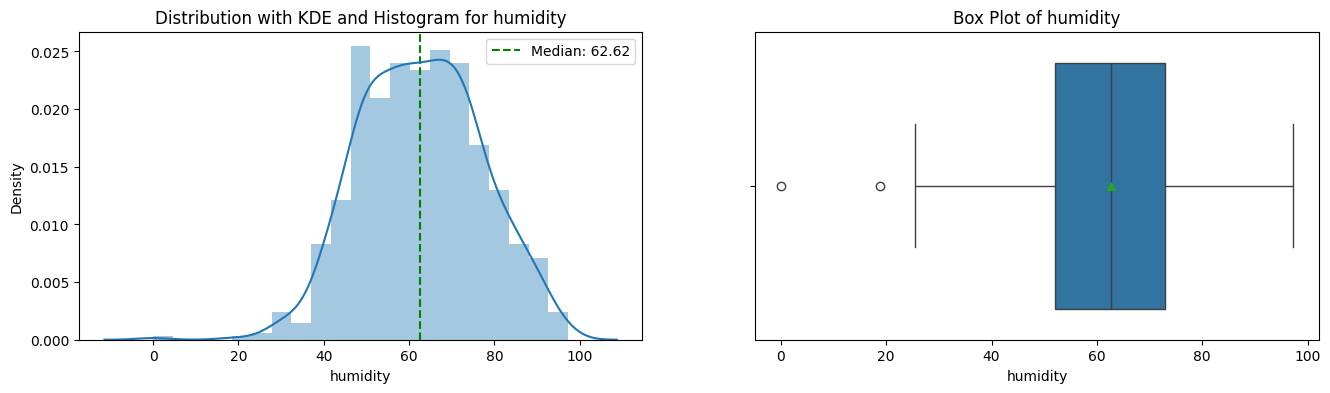

In [ ]:
analyze_column_against_count(bikes, 'humidity')

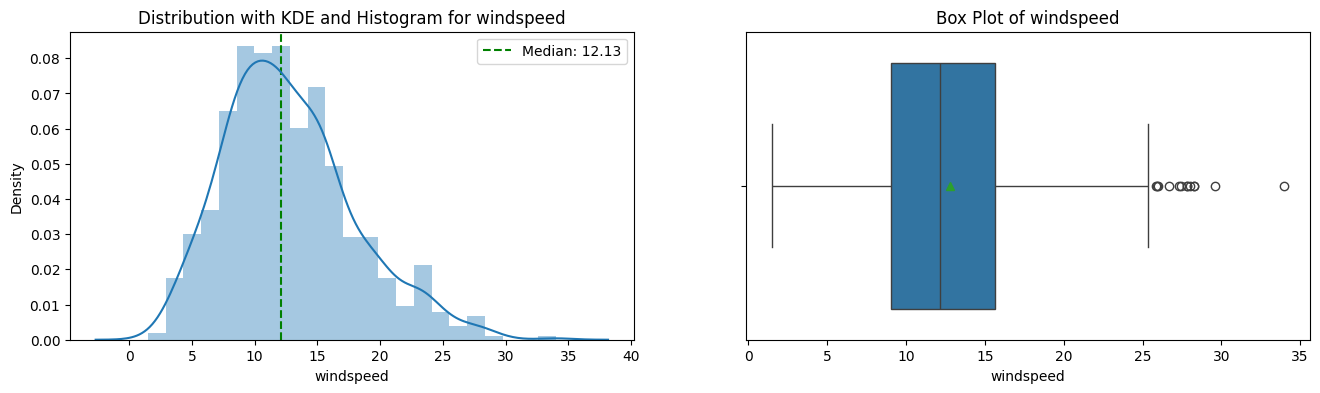

In [ ]:
analyze_column_against_count(bikes, 'windspeed')

# Prepare Data for Model Building

In [ ]:
# identify all categorical variables
categorical_bikes_data = bikes.select_dtypes(include=['object']).drop(['weather'], axis=1)
categorical_bikes_data.info()
categorical_bikes_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   season   730 non-null    object
 1   month    730 non-null    object
 2   weekday  730 non-null    object
dtypes: object(3)
memory usage: 17.2+ KB


,season,month,weekday
0,Spring,Jan,Mon
1,Spring,Jan,Tue
2,Spring,Jan,Wed
3,Spring,Jan,Thu
4,Spring,Jan,Fri


In [ ]:
categorical_data_dummies_df = pd.get_dummies(categorical_bikes_data, drop_first=True)
weather_dummies = pd.get_dummies(bikes.weather)
print(categorical_data_dummies_df.head())
print(weather_dummies.head())

   season_Spring  season_Summer  season_Winter  month_Aug  month_Dec  \
0              1              0              0          0          0   
1              1              0              0          0          0   
2              1              0              0          0          0   
3              1              0              0          0          0   
4              1              0              0          0          0   

   month_Feb  month_Jan  month_Jul  month_Jun  month_Mar  month_May  \
0          0          1          0          0          0          0   
1          0          1          0          0          0          0   
2          0          1          0          0          0          0   
3          0          1          0          0          0          0   
4          0          1          0          0          0          0   

   month_Nov  month_Oct  month_Sep  weekday_Mon  weekday_Sat  weekday_Sun  \
0          0          0          0            1            0   

In [ ]:
processed_bikes_data = pd.concat([bikes, categorical_data_dummies_df, weather_dummies], axis=1)
processed_bikes_data.drop(bikes.select_dtypes(include=['object']).columns, axis=1, inplace=True)

In [ ]:
processed_bikes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year           730 non-null    int64  
 1   holiday        730 non-null    int64  
 2   workingday     730 non-null    int64  
 3   temp           730 non-null    float64
 4   humidity       730 non-null    float64
 5   windspeed      730 non-null    float64
 6   cnt            730 non-null    int64  
 7   season_Spring  730 non-null    uint8  
 8   season_Summer  730 non-null    uint8  
 9   season_Winter  730 non-null    uint8  
 10  month_Aug      730 non-null    uint8  
 11  month_Dec      730 non-null    uint8  
 12  month_Feb      730 non-null    uint8  
 13  month_Jan      730 non-null    uint8  
 14  month_Jul      730 non-null    uint8  
 15  month_Jun      730 non-null    uint8  
 16  month_Mar      730 non-null    uint8  
 17  month_May      730 non-null    uint8  
 18  month_Nov 

We now have all numerical data that could be used to build the model. Lets look at how the data looks like

# Model Building

In [ ]:
processed_bikes_data.head()

,year,holiday,workingday,temp,humidity,windspeed,cnt,season_Spring,season_Summer,season_Winter,...,month_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,Clear,LightSnow,Mist
0,0,0,0,14.110847,80.5833,10.749882,985,1,0,0,...,0,1,0,0,0,0,0,0,0,1
1,0,0,0,14.902598,69.6087,16.652113,801,1,0,0,...,0,0,0,0,0,1,0,0,0,1
2,0,0,1,8.050924,43.7273,16.636703,1349,1,0,0,...,0,0,0,0,0,0,1,1,0,0
3,0,0,1,8.200000,59.0435,10.739832,1562,1,0,0,...,0,0,0,0,1,0,0,1,0,0
4,0,0,1,9.305237,43.6957,12.522300,1600,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
processed_bikes_data.shape

(730, 30)

## Lets split the processed data into training and test sets in the 70:30 ratio

In [ ]:
np.random.seed(0)
df_train, df_test = train_test_split(processed_bikes_data, train_size=0.70, test_size=0.30, random_state=35)
df_train.head()

,year,holiday,workingday,temp,humidity,windspeed,cnt,season_Spring,season_Summer,season_Winter,...,month_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,Clear,LightSnow,Mist
499,1,0,1,25.078347,79.4583,9.875264,5115,0,1,0,...,0,0,0,0,1,0,0,0,0,1
298,0,0,1,19.850847,72.0417,9.959014,3894,0,0,1,...,0,0,0,0,0,0,0,0,0,1
703,1,0,1,17.971653,48.5000,21.709407,5729,0,0,1,...,0,0,0,0,0,0,0,1,0,0
203,0,0,0,34.815847,50.0000,8.791807,3285,0,0,0,...,0,1,0,0,0,0,0,1,0,0
405,1,0,1,11.514153,54.0000,7.834243,3831,1,0,0,...,0,0,0,1,0,0,0,0,0,1


In [ ]:
print(df_train.shape)
print(df_test.shape)

(510, 30)
(219, 30)


## Feature Scaling of the Training dataset
From above we can see that some columns are having larger float values, whereas other's are in the range between 0 and 1, Therefore, in order to have uniformity across all the data lets scale the numerical columns that has values greater than one. We will be using Min-Max scaling (normalization) so that all the resultant values are between 0 and 1

In [ ]:
scale_columns = ['temp', 'humidity', 'windspeed', 'cnt']
scaler = MinMaxScaler()
df_train[scale_columns] = scaler.fit_transform(df_train[scale_columns])
df_train.head()

,year,holiday,workingday,temp,humidity,windspeed,cnt,season_Spring,season_Summer,season_Winter,...,month_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,Clear,LightSnow,Mist
499,1,0,1,0.688488,0.817052,0.298208,0.596859,0,1,0,...,0,0,0,0,1,0,0,0,0,1
298,0,0,1,0.529616,0.740789,0.301190,0.453768,0,0,1,...,0,0,0,0,0,0,0,0,0,1
703,1,0,1,0.472505,0.498715,0.719585,0.668815,0,0,1,...,0,0,0,0,0,0,0,1,0,0
203,0,0,0,0.984424,0.514139,0.259630,0.382398,0,0,0,...,0,1,0,0,0,0,0,1,0,0
405,1,0,1,0.276252,0.555270,0.225534,0.446385,1,0,0,...,0,0,0,1,0,0,0,0,0,1


In [ ]:
df_train.describe()

,year,holiday,workingday,temp,humidity,windspeed,cnt,season_Spring,season_Summer,season_Winter,...,month_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,Clear,LightSnow,Mist
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,...,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.494118,0.031373,0.680392,0.548465,0.642973,0.401444,0.523996,0.237255,0.241176,0.241176,...,0.096078,0.143137,0.131373,0.149020,0.147059,0.145098,0.137255,0.649020,0.029412,0.321569
std,0.500456,0.174494,0.466782,0.231570,0.148183,0.186596,0.226933,0.425818,0.428217,0.428217,...,0.294988,0.350557,0.338139,0.356457,0.354512,0.352545,0.344454,0.477745,0.169124,0.467537
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.342969,0.535240,0.273353,0.358022,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.557133,0.645673,0.374603,0.535451,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.753646,0.749572,0.500735,0.689148,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


From above data, we can see there is uniformity now in all the data that ranges between 0 and 1

Let's repeat and now analyse the correlation between the feature variables to check for assumptions in linear regression

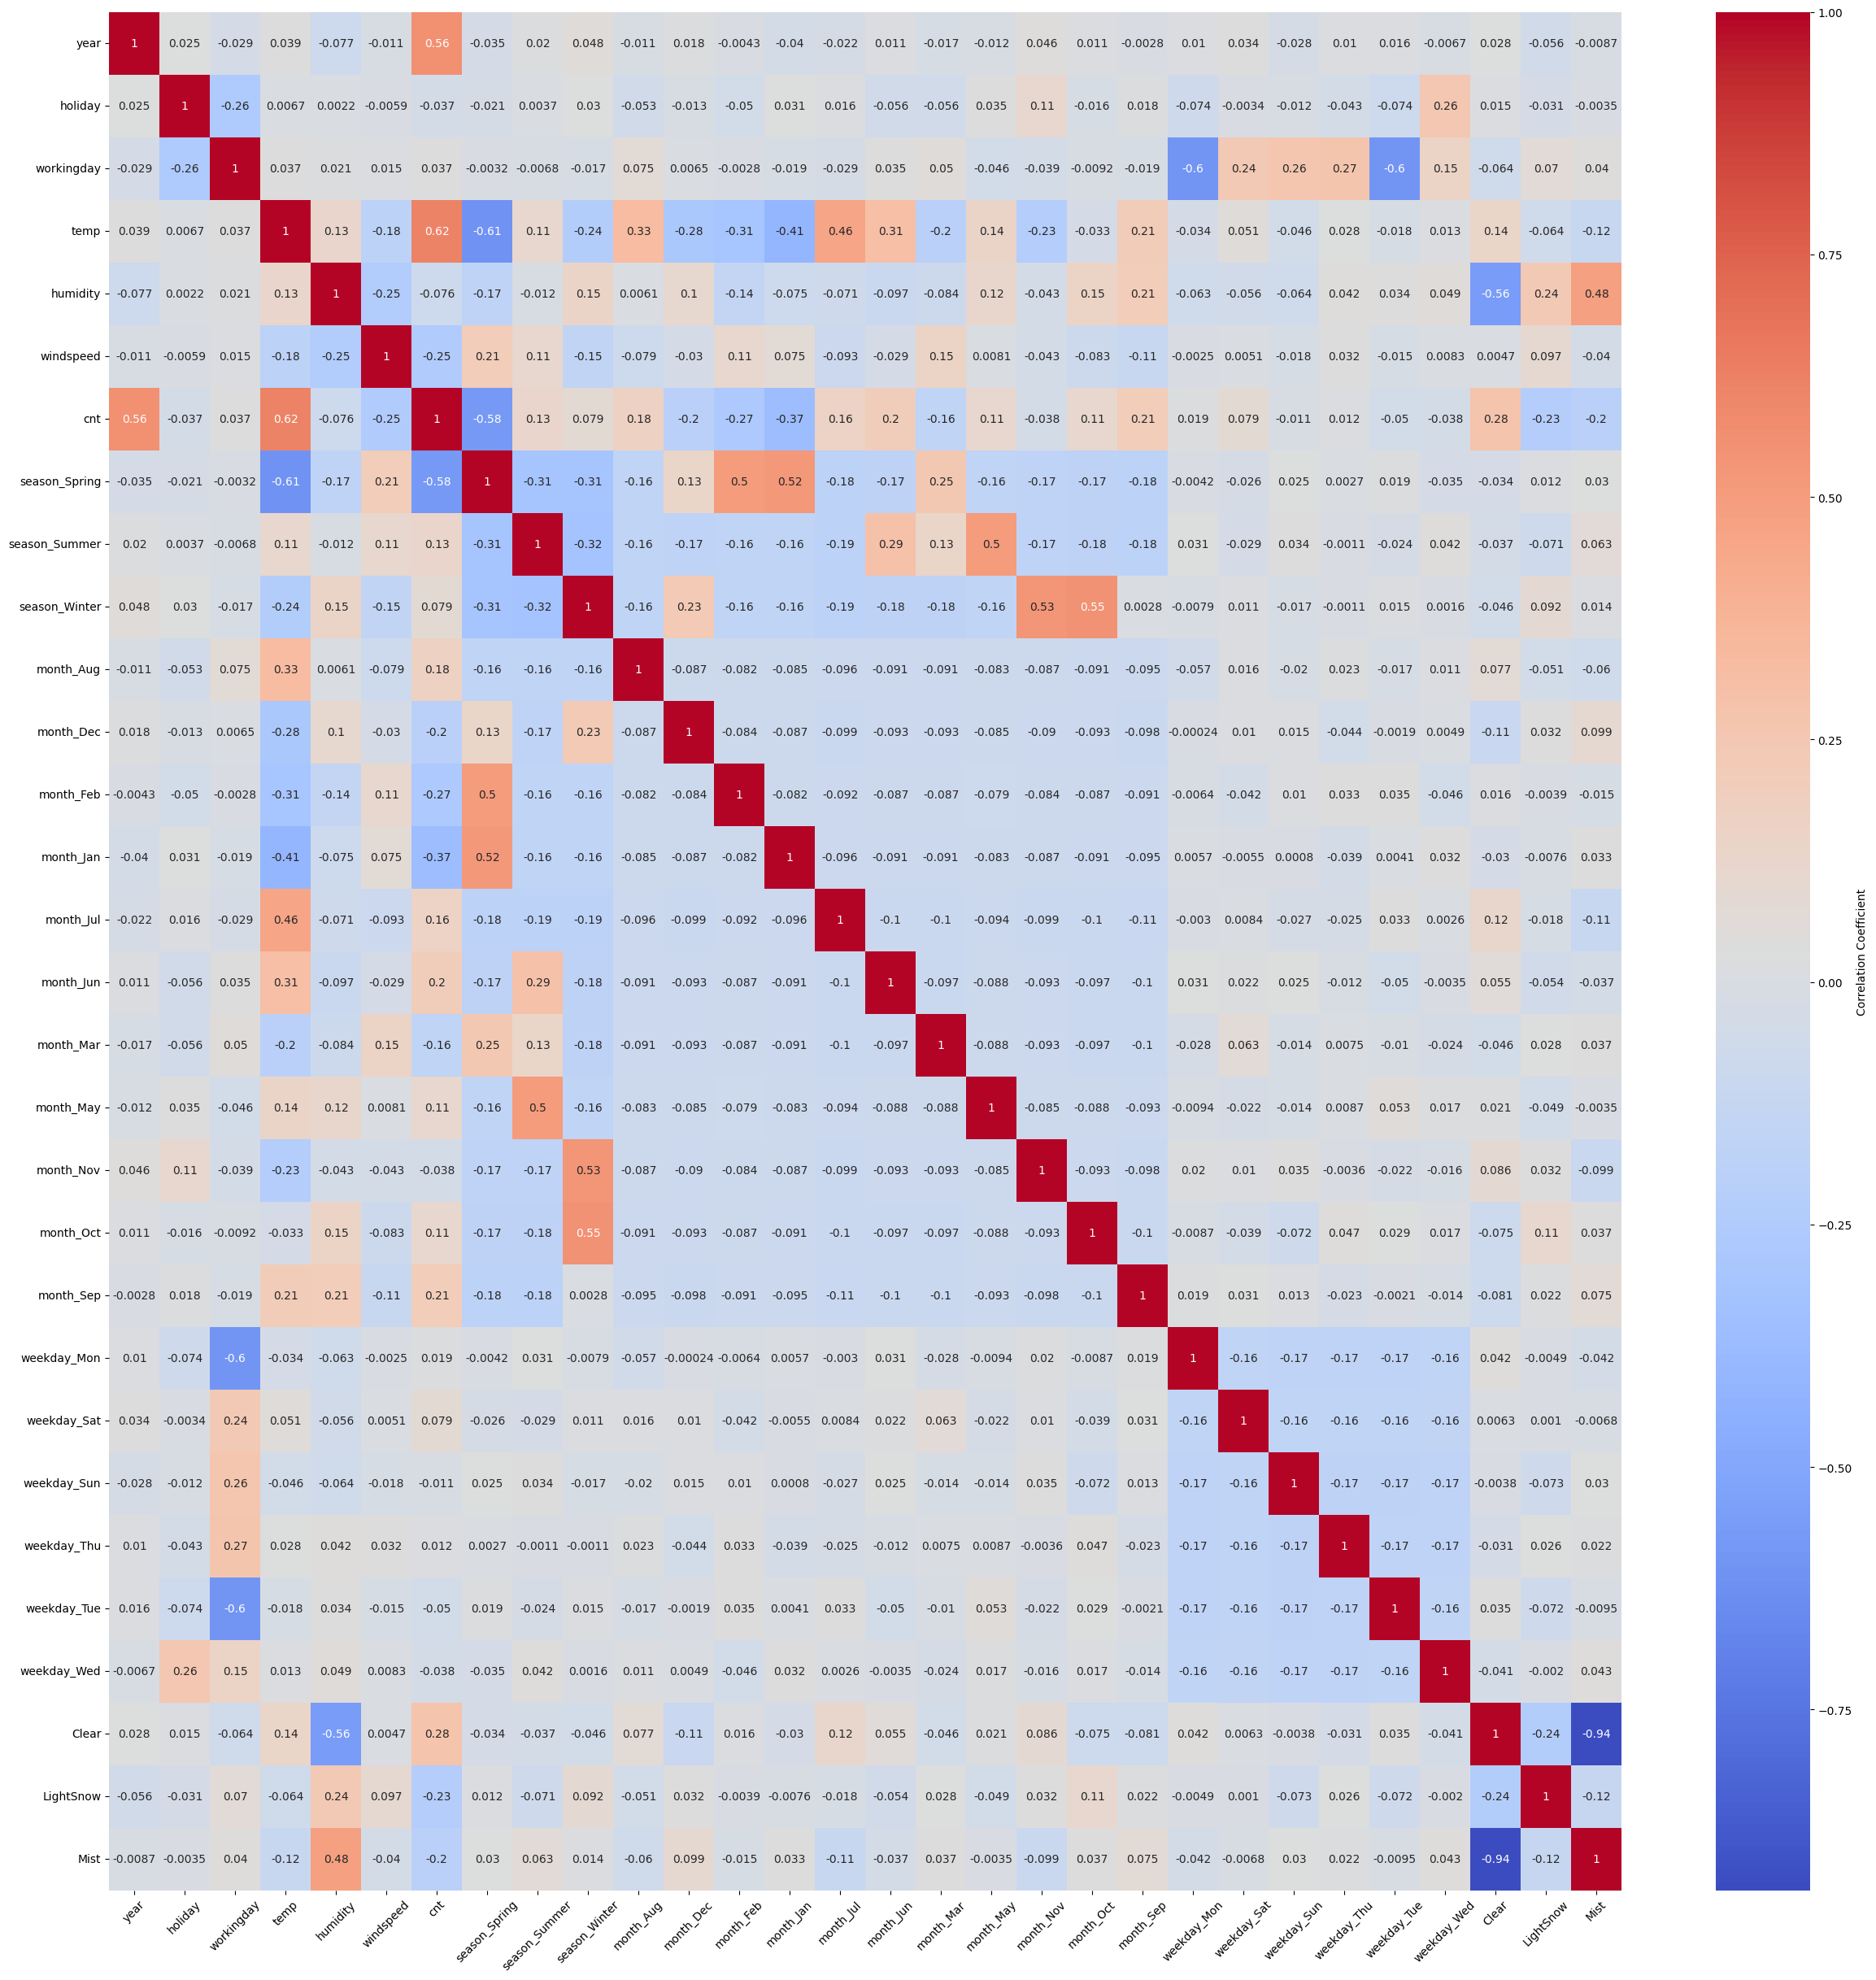

In [ ]:
correlationMatrix = df_train.corr()
plt.figure(figsize = (30, 30))
#print(correlationMatrix)
sns.heatmap(correlationMatrix, annot=True, cmap='coolwarm', xticklabels=correlationMatrix.columns,
            cbar_kws={"label": "Correlation Coefficient"})
plt.xticks(rotation=45)
plt.show()

We can see that the temperature is having the highest correlation 0.65 among all the other variables

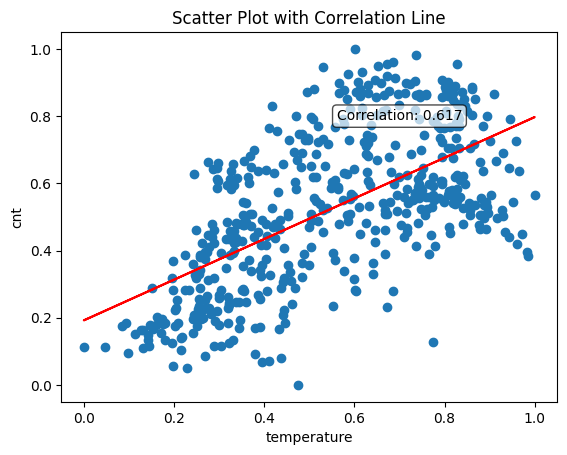

In [ ]:
draw_scatter_plot_with_correlation_line(df_train, 'temp', 'cnt')

This confirms that there is a positive correlation between temperature and bike rental count.

## Split into X and y training datasets

In [ ]:
y_train = df_train.pop('cnt')
X_train = df_train

In [ ]:
X_train.head()

,year,holiday,workingday,temp,humidity,windspeed,season_Spring,season_Summer,season_Winter,month_Aug,...,month_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,Clear,LightSnow,Mist
499,1,0,1,0.688488,0.817052,0.298208,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
298,0,0,1,0.529616,0.740789,0.301190,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
703,1,0,1,0.472505,0.498715,0.719585,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
203,0,0,0,0.984424,0.514139,0.259630,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
405,1,0,1,0.276252,0.555270,0.225534,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1


## Model 1

In [ ]:
# In first model we buiild using all columns
lr = build_statsmodel_ols(X_train, y_train)

const            0.175562
year             0.234455
holiday          0.006572
workingday       0.078231
temp             0.363474
humidity        -0.131477
windspeed       -0.140059
season_Spring   -0.088960
season_Summer    0.005735
season_Winter    0.090740
month_Aug        0.006441
month_Dec       -0.086926
month_Feb       -0.055717
month_Jan       -0.070571
month_Jul       -0.037760
month_Jun        0.017624
month_Mar       -0.011377
month_May        0.036264
month_Nov       -0.097755
month_Oct        0.002855
month_Sep        0.066773
weekday_Mon      0.067023
weekday_Sat      0.000347
weekday_Sun     -0.008978
weekday_Thu     -0.015274
weekday_Tue      0.023735
weekday_Wed     -0.030099
Clear            0.160382
LightSnow       -0.075719
Mist             0.090900
dtype: float64


In [ ]:
# Check the summary
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     92.17
Date:                Wed, 20 Mar 2024   Prob (F-statistic):          2.48e-171
Time:                        15:45:44   Log-Likelihood:                 496.96
No. Observations:                 510   AIC:                            -937.9
Df Residuals:                     482   BIC:                            -819.3
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1756      0.032      5.554

This model has an adjust R-Squared value of 83% which is very good **but** the number of feature variables is 29. Some of the feature variables have a p-value of greater than 0.05 (5% significance), We can either manually remove all the high value ones manually or use an automated RFE technique that uses a recursive feature elimination technique to eliminate irrelevant ones and build a good model with statistically significant variables only.
Also, We can see that atleast 14 variables have p-value > 0.05, which means we can just consider the top 15 out of 29 variables to start with.

## Model 2 building using the automated RFE Method

In [ ]:
rfe = compute_and_return_rfe(X_train, y_train, 15)

In [ ]:
# Lets look at the variables selected by using recursion by RFE and their respective ranking or weightage
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('year', True, 1),
 ('holiday', False, 3),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('humidity', True, 1),
 ('windspeed', True, 1),
 ('season_Spring', True, 1),
 ('season_Summer', False, 13),
 ('season_Winter', True, 1),
 ('month_Aug', False, 12),
 ('month_Dec', True, 1),
 ('month_Feb', False, 2),
 ('month_Jan', True, 1),
 ('month_Jul', True, 1),
 ('month_Jun', False, 8),
 ('month_Mar', False, 9),
 ('month_May', False, 6),
 ('month_Nov', True, 1),
 ('month_Oct', False, 14),
 ('month_Sep', True, 1),
 ('weekday_Mon', True, 1),
 ('weekday_Sat', False, 15),
 ('weekday_Sun', False, 11),
 ('weekday_Thu', False, 10),
 ('weekday_Tue', False, 5),
 ('weekday_Wed', False, 7),
 ('Clear', True, 1),
 ('LightSnow', True, 1),
 ('Mist', False, 4)]

Lets now find the statistics of the trained model using statsmodel summary

In [ ]:
X_train_rfe = get_stats_summary(X_train, rfe.support_)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     163.7
Date:                Wed, 20 Mar 2024   Prob (F-statistic):          1.41e-180
Time:                        15:45:44   Log-Likelihood:                 488.82
No. Observations:                 510   AIC:                            -945.6
Df Residuals:                     494   BIC:                            -877.9
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2741      0.039      7.029

In [ ]:
X_train_rfe.columns

Index(['const', 'year', 'workingday', 'temp', 'humidity', 'windspeed',
       'season_Spring', 'season_Winter', 'month_Dec', 'month_Jan', 'month_Jul',
       'month_Nov', 'month_Sep', 'weekday_Mon', 'Clear', 'LightSnow'],
      dtype='object')

In [ ]:
~rfe.support_

array([False,  True, False, False, False, False, False,  True, False,
        True, False,  True, False, False,  True,  True,  True, False,
        True, False, False,  True,  True,  True,  True,  True, False,
       False,  True])

In [ ]:
drop_columns = X_train.columns[~rfe.support_]
drop_columns

Index(['holiday', 'season_Summer', 'month_Aug', 'month_Feb', 'month_Jun',
       'month_Mar', 'month_May', 'month_Oct', 'weekday_Sat', 'weekday_Sun',
       'weekday_Thu', 'weekday_Tue', 'weekday_Wed', 'Mist'],
      dtype='object')

Here some important considerations:
- The adjusted R-Squared value which is approximately 83% signifies these metrics indicate the proportion of variance is explained by the model. They can complement the F-statistic in evaluating model fit as noted below.
- Large F-statistic suggests strong evidence that the model explains the data significantly better than a null model (intercept-only model).
- Low prob (F-Statistic, less than significance level, e.g., < 0.05): Rejects the null hypothesis, indicating a statistically significant difference between the model and the null model.
- The P-Value of individual feature variables are also less than 0.05 except month_Jan, So we still have opportunity to improve the model.

###Check the VIF values
The Varaince Inflation Factor or VIF  provides quantitative data about how much the feature variables are correlated to each other.

In [ ]:
drop_columns = drop_columns.tolist() + ['month_Jan']
X_train_m2 = X_train.drop(drop_columns, axis=1)
print_vif_data(X_train_m2)

         Features    VIF
2            temp  19.17
3        humidity  17.99
4       windspeed   5.13
1      workingday   4.56
12          Clear   3.69
5   season_Spring   2.81
6   season_Winter   2.72
0            year   1.99
9       month_Nov   1.77
11    weekday_Mon   1.72
8       month_Jul   1.56
7       month_Dec   1.38
10      month_Sep   1.28
13      LightSnow   1.14


temp and humidity are having very high VIF values, but model ranking shows temp is very important and also confirmed by it p value that this variable is statistically significant to the model. Lets now build 3rd model using the above information

## Model 3

In [ ]:
drop_columns = list(drop_columns) + ['humidity']
X_train_m3 = X_train.drop(drop_columns, axis=1)
X_train_lr3 = build_statsmodel_ols(X_train=X_train_m3, y_train=y_train)
print(X_train_lr3.summary())

const            0.170853
year             0.236550
workingday       0.052422
temp             0.388172
windspeed       -0.115628
season_Spring   -0.134684
season_Winter    0.075023
month_Dec       -0.066210
month_Jul       -0.055389
month_Nov       -0.090070
month_Sep        0.047117
weekday_Mon      0.054075
Clear            0.091342
LightSnow       -0.179449
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     182.8
Date:                Wed, 20 Mar 2024   Prob (F-statistic):          1.32e-179
Time:                        15:45:45   Log-Likelihood:                 481.10
No. Observations:                 510   AIC:                            -934.2
Df Residuals:                     496   BIC:                        

In [ ]:
# Lets look at the variables selected by using recursion by RFE and their respective ranking or weightage
list(zip(X_train_m3.columns, rfe.support_, rfe.ranking_))

[('year', True, 1),
 ('workingday', False, 3),
 ('temp', True, 1),
 ('windspeed', True, 1),
 ('season_Spring', True, 1),
 ('season_Winter', True, 1),
 ('month_Dec', True, 1),
 ('month_Jul', False, 13),
 ('month_Nov', True, 1),
 ('month_Sep', False, 12),
 ('weekday_Mon', True, 1),
 ('Clear', False, 2),
 ('LightSnow', True, 1)]

We could lookout for the following variables:
- workingday
- month_Jan
- month_Sep
- weekday_Mon       
- Clear

###Check the VIF values

In [ ]:
print_vif_data(X_train_m3)

         Features   VIF
2            temp  8.28
3       windspeed  5.00
1      workingday  4.42
11          Clear  3.18
5   season_Winter  2.29
4   season_Spring  2.01
0            year  1.99
8       month_Nov  1.74
10    weekday_Mon  1.68
7       month_Jul  1.49
6       month_Dec  1.33
9       month_Sep  1.27
12      LightSnow  1.13


humidity and Windspeed are having values >= 5, so there is still room to improve the model

Considering that we now have just 13 features, we still have good adjusted r-squared of 82%, which is a great improvement. We can try to reduce the features and try to still get a good Adjusted R-Squared with minimal number of features.
From above we can see that

## Model 4

Let us now build a new model by removing Working day as it is having high VIF as well low ranking

In [ ]:
drop_columns = list(drop_columns) + ['workingday']
X_train_m4 = X_train.drop(drop_columns, axis=1)
X_train_lr4 = build_statsmodel_ols(X_train=X_train_m4, y_train=y_train)
print(X_train_lr4.summary())

const            0.211319
year             0.235537
temp             0.393508
windspeed       -0.114885
season_Spring   -0.135001
season_Winter    0.073607
month_Dec       -0.064995
month_Jul       -0.060131
month_Nov       -0.090919
month_Sep        0.044765
weekday_Mon      0.012702
Clear            0.090114
LightSnow       -0.170151
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     188.6
Date:                Wed, 20 Mar 2024   Prob (F-statistic):          2.88e-176
Time:                        15:45:45   Log-Likelihood:                 470.42
No. Observations:                 510   AIC:                            -914.8
Df Residuals:                     497   BIC:                            -859.8
Df Model:      

In [ ]:
# Lets look at the variables selected by using recursion by RFE and their respective ranking or weightage
list(zip(X_train_m4.columns, rfe.support_, rfe.ranking_))

[('year', True, 1),
 ('temp', False, 3),
 ('windspeed', True, 1),
 ('season_Spring', True, 1),
 ('season_Winter', True, 1),
 ('month_Dec', True, 1),
 ('month_Jul', True, 1),
 ('month_Nov', False, 13),
 ('month_Sep', True, 1),
 ('weekday_Mon', False, 12),
 ('Clear', True, 1),
 ('LightSnow', False, 2)]

###Check the VIF values

In [ ]:
print_vif_data(X_train_m4)

         Features   VIF
1            temp  6.33
2       windspeed  4.84
10          Clear  3.18
4   season_Winter  2.25
0            year  1.99
3   season_Spring  1.85
7       month_Nov  1.73
6       month_Jul  1.47
5       month_Dec  1.32
8       month_Sep  1.27
9     weekday_Mon  1.16
11      LightSnow  1.12


We still have high VIF values and need to eliminate several columns weekdy_mon and september data, we will do one by one

## Model 5

In [ ]:
#Lets remove Weeday_Mon that seems to be an influential variable with high p-value and also based on rfe ranking
drop_columns = list(drop_columns) + ['weekday_Mon']
X_train_m5 = X_train.drop(drop_columns, axis=1)
X_train_lr5 = build_statsmodel_ols(X_train=X_train_m5, y_train=y_train)
print(X_train_lr5.summary())

const            0.214498
year             0.235666
temp             0.391015
windspeed       -0.115185
season_Spring   -0.135907
season_Winter    0.072876
month_Dec       -0.064938
month_Jul       -0.059739
month_Nov       -0.090704
month_Sep        0.045344
Clear            0.090626
LightSnow       -0.169929
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     205.6
Date:                Wed, 20 Mar 2024   Prob (F-statistic):          3.32e-177
Time:                        15:45:45   Log-Likelihood:                 469.88
No. Observations:                 510   AIC:                            -915.8
Df Residuals:                     498   BIC:                            -865.0
Df Model:                          11    

In [ ]:
# Lets look at the variables selected by using recursion by RFE and their respective ranking or weightage
list(zip(X_train_m5.columns, rfe.support_, rfe.ranking_))

[('year', True, 1),
 ('temp', False, 3),
 ('windspeed', True, 1),
 ('season_Spring', True, 1),
 ('season_Winter', True, 1),
 ('month_Dec', True, 1),
 ('month_Jul', True, 1),
 ('month_Nov', False, 13),
 ('month_Sep', True, 1),
 ('Clear', False, 12),
 ('LightSnow', True, 1)]

###Check the VIF values

In [ ]:
print_vif_data(X_train_m5)

         Features   VIF
1            temp  6.32
2       windspeed  4.83
9           Clear  3.17
4   season_Winter  2.25
0            year  1.99
3   season_Spring  1.85
7       month_Nov  1.73
6       month_Jul  1.47
5       month_Dec  1.32
8       month_Sep  1.26
10      LightSnow  1.12


## Model 6

Lets remove month_Jul as its having high negative correlation and high p-values

In [ ]:
drop_columns

['holiday',
 'season_Summer',
 'month_Aug',
 'month_Feb',
 'month_Jun',
 'month_Mar',
 'month_May',
 'month_Oct',
 'weekday_Sat',
 'weekday_Sun',
 'weekday_Thu',
 'weekday_Tue',
 'weekday_Wed',
 'Mist',
 'month_Jan',
 'humidity',
 'workingday',
 'weekday_Mon']

In [ ]:
drop_columns_m6 = list(drop_columns) + ['month_Jul']
X_train_m6 = X_train.drop(drop_columns_m6, axis=1)
X_train_lr6 = build_statsmodel_ols(X_train=X_train_m6, y_train=y_train)
print(X_train_lr6.summary())

const            0.232649
year             0.237185
temp             0.345147
windspeed       -0.111274
season_Spring   -0.141668
season_Winter    0.075216
month_Dec       -0.068424
month_Nov       -0.095534
month_Sep        0.057460
Clear            0.089475
LightSnow       -0.173342
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     220.0
Date:                Wed, 20 Mar 2024   Prob (F-statistic):          9.10e-176
Time:                        15:45:45   Log-Likelihood:                 463.68
No. Observations:                 510   AIC:                            -905.4
Df Residuals:                     499   BIC:                            -858.8
Df Model:                          10                              

In [ ]:
# Lets look at the variables selected by using recursion by RFE and their respective ranking or weightage
list(zip(X_train_m6.columns, rfe.support_, rfe.ranking_))

[('year', True, 1),
 ('temp', False, 3),
 ('windspeed', True, 1),
 ('season_Spring', True, 1),
 ('season_Winter', True, 1),
 ('month_Dec', True, 1),
 ('month_Nov', True, 1),
 ('month_Sep', False, 13),
 ('Clear', True, 1),
 ('LightSnow', False, 12)]

In [ ]:
print_vif_data(X_train_m6)

        Features   VIF
1           temp  5.18
2      windspeed  4.70
8          Clear  3.17
4  season_Winter  2.20
0           year  1.98
3  season_Spring  1.85
6      month_Nov  1.73
5      month_Dec  1.32
7      month_Sep  1.20
9      LightSnow  1.12


We have very good adjusted R-Square of 81.1%. All the pvalues are very less significant. We could still improve to bringdown the VIF of all variables less than 5. Lets try to improve it even better

##Model 7

In [ ]:
# LightSnow. december month sales and november month sales might be the next set of variables to target
drop_columns_m7 = list(drop_columns) + ['month_Dec','LightSnow','month_Nov']
X_train_m7 = X_train.drop(drop_columns_m7, axis=1)
X_train_sm7 = sm.add_constant(X_train_m7)
X_train_lr7 = sm.OLS(y_train, X_train_sm7).fit()
print(X_train_lr7.params)
print(X_train_lr7.summary())


const            0.181748
year             0.236562
temp             0.432545
windspeed       -0.129456
season_Spring   -0.130985
season_Winter    0.031163
month_Jul       -0.070643
month_Sep        0.051026
Clear            0.101193
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     243.1
Date:                Wed, 20 Mar 2024   Prob (F-statistic):          4.45e-167
Time:                        15:45:45   Log-Likelihood:                 437.51
No. Observations:                 510   AIC:                            -857.0
Df Residuals:                     501   BIC:                            -818.9
Df Model:                           8                                         
Covariance Type:            nonrobust   

In [ ]:
# Lets look at the variables selected by using recursion by RFE and their respective ranking or weightage
list(zip(X_train_m7.columns, rfe.support_, rfe.ranking_))

[('year', True, 1),
 ('temp', False, 3),
 ('windspeed', True, 1),
 ('season_Spring', True, 1),
 ('season_Winter', True, 1),
 ('month_Jul', True, 1),
 ('month_Sep', True, 1),
 ('Clear', False, 13)]

In [ ]:
print_vif_data(X_train_m7)

        Features   VIF
1           temp  6.12
2      windspeed  4.69
7          Clear  2.91
0           year  1.97
3  season_Spring  1.76
5      month_Jul  1.47
4  season_Winter  1.37
6      month_Sep  1.25


## Inference
We now have all the pvalues to be 0 and VIF values in a permissible range. Also, the adjustted R-squared value has dropped from 82% with 30 variables to just 79% using just 7 variables. The model is also explaining most of the variance without being too complex. So we can now proceed with this model to evaluate and analyse using the test data set


F-Statistics value of 268 (which is greater than 1) and the p-value of 4.83e-165 i.e almost equals to zero, states that the overall model is significant

# Model Evaluation

In [ ]:
X_train_lr7.params

const            0.181748
year             0.236562
temp             0.432545
windspeed       -0.129456
season_Spring   -0.130985
season_Winter    0.031163
month_Jul       -0.070643
month_Sep        0.051026
Clear            0.101193
dtype: float64

## Residual Analysis

In [ ]:
X_train_m7.head()

,year,temp,windspeed,season_Spring,season_Winter,month_Jul,month_Sep,Clear
499,1,0.688488,0.298208,0,0,0,0,0
298,0,0.529616,0.301190,0,1,0,0,0
703,1,0.472505,0.719585,0,1,0,0,1
203,0,0.984424,0.259630,0,0,1,0,1
405,1,0.276252,0.225534,1,0,0,0,0


In [ ]:
y_train_pred = X_train_lr7.predict(X_train_sm7)

In [ ]:
residuals = (y_train-y_train_pred)

###Plot the Error Terms

###Normality check

Text(0.5, 0, 'Errors')

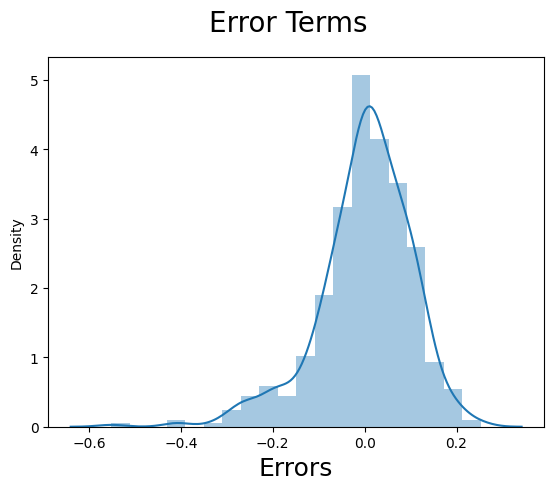

In [ ]:
# Let us plot the histogram of the error terms
fig = plt.figure()
sns.distplot(residuals, bins = 20)
fig.suptitle('Error Terms', fontsize = 20)
plt.xlabel('Errors', fontsize = 18)

The error terms are very nicely normally distributed with mean 0.

### Homoscedasticity (Constant Variance of Residuals):

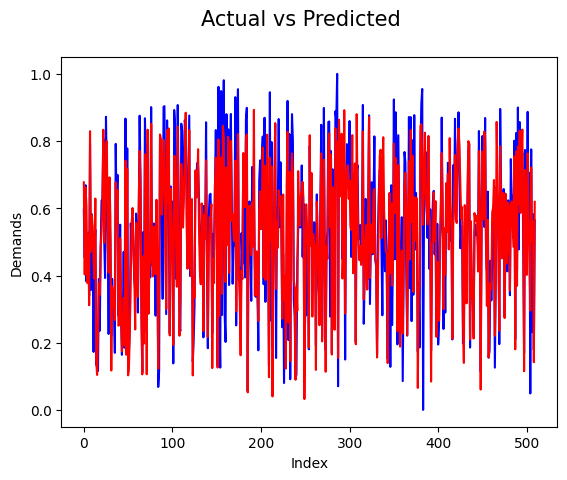

In [ ]:
# Plot residuals as Actual vs Predicted
c = [i for i in range(0,len(X_train),1)]
plt.plot(c,y_train, color="blue")
plt.plot(c,y_train_pred, color="red")
plt.suptitle('Actual vs Predicted', fontsize = 15)
plt.xlabel('Index')
plt.ylabel('Demands')
plt.show()

We can see that the Actual and predicted are following almost the same pattern, so this model looks nice.

Lets plot the residuals for linearity check


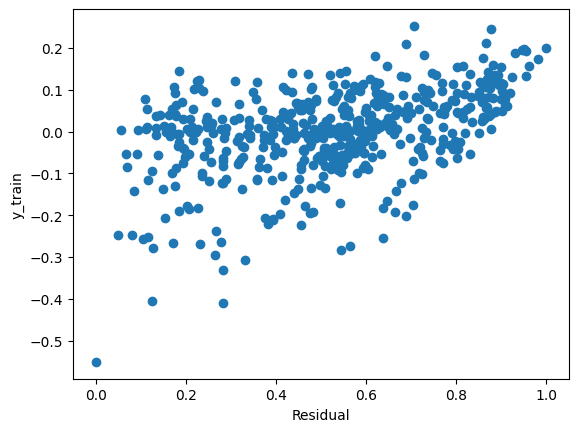

In [ ]:
plt.scatter(y_train, residuals)
plt.ylabel("y_train")
plt.xlabel("Residual")
plt.show()

No visible pattern observed from above plot for residuals.

### Multicollinearity check

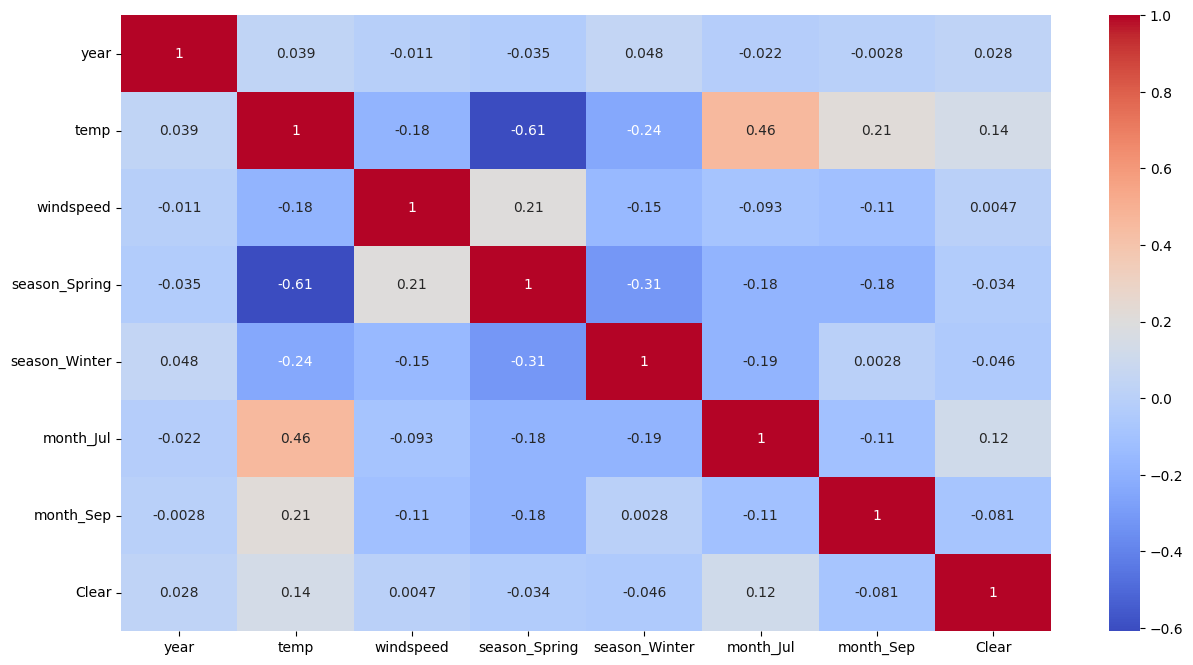

In [ ]:
plt.figure(figsize=(15,8))
sns.heatmap(X_train_m7.corr(),annot = True, cmap="coolwarm")
plt.show()

VIF values are less than or equal to 5 which is good and also there is no multicolinearity as seen from the heatmap.

##Estimate, plot and evaluated predicted Values

In [ ]:
# We would first need to scale the test set as well. So let's start with that.
X_train_sm7

,const,year,temp,windspeed,season_Spring,season_Winter,month_Jul,month_Sep,Clear
499,1.0,1,0.688488,0.298208,0,0,0,0,0
298,1.0,0,0.529616,0.301190,0,1,0,0,0
703,1.0,1,0.472505,0.719585,0,1,0,0,1
203,1.0,0,0.984424,0.259630,0,0,1,0,1
405,1.0,1,0.276252,0.225534,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...
651,1.0,1,0.576343,0.611254,0,1,0,0,1
249,1.0,0,0.672912,0.178040,0,0,0,1,0
448,1.0,1,0.471467,0.473275,0,0,0,0,0
33,1.0,0,0.159278,0.609203,1,0,0,0,1


In [ ]:
scale_columns

['temp', 'humidity', 'windspeed', 'cnt']

In [ ]:
df_test[scale_columns] = scaler.transform(df_test[scale_columns])

In [ ]:
df_test.head()

,year,holiday,workingday,temp,humidity,windspeed,cnt,season_Spring,season_Summer,season_Winter,...,month_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,Clear,LightSnow,Mist
710,1,0,1,0.297020,0.553556,0.335293,0.620766,0,0,1,...,0,0,0,0,0,0,0,0,0,1
138,0,0,1,0.587765,0.853042,0.204740,0.533576,0,1,0,...,0,0,1,0,0,0,0,0,0,1
607,1,0,1,0.878510,0.604113,0.348643,0.858784,0,0,0,...,0,0,0,1,0,0,0,1,0,0
392,1,0,0,0.319864,0.558697,0.449547,0.468886,1,0,0,...,0,1,0,0,0,0,0,1,0,0
72,0,0,1,0.331557,0.511010,0.273240,0.237197,1,0,0,...,0,0,0,0,0,0,1,1,0,0


In [ ]:
# Split the 'df_test' set into X and y after scaling
y_test = df_test.pop('cnt')
X_test = df_test

In [ ]:
X_test_m7 = X_test.drop(drop_columns_m7, axis=1)
X_test_sm7 = sm.add_constant(X_test_m7)
y_pred = X_train_lr7.predict(X_test_sm7)


Text(0, 0.5, 'y_pred')

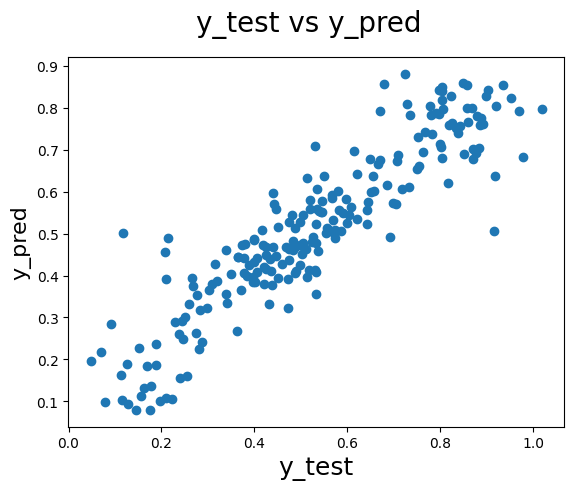

In [ ]:
# Plotting y_test and y_pred to understand the spread

fig = plt.figure()
plt.scatter(y_test, y_pred)
fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_pred', fontsize = 16)

**Inference**
We can observe that variance of the residuals (error terms) is constant across predictions. i.e error term does not vary much as the value of the predictor variable changes.

In [ ]:
r2_score(y_test, y_pred)

0.8164367250110236

Thus, the R squared value between test and predicted test data sets is very nice compared to the prediction done with training data set. R2 value for predictions on test data (0.809) is better than R2 value of train data(0.789). This is a good R-squared value, hence we can see our model is performing good even on unseen data (test data)


# Conclusion

Significant variables to predict the demand for shared bikes

- year (2019)
- temp             
- windspeed
- season_Spring   
- season_Winter    
- month_Sep       
- Clear

Thus, the final model consists of the 7 variables mentioned above and the bikes rental company could go ahead with this model and use it for predicting count of daily bike rentals.